In [135]:
import numpy as np
from collections import defaultdict
import time
import matplotlib.pyplot as plt
import seaborn as sn
from matplotlib.colors import LinearSegmentedColormap

W = LinearSegmentedColormap.from_list('w', ["w", "w"], N=256)



In [136]:
ACTIONS = {
    0: [1, 0],   # south
    1: [-1, 0],  # north
    2: [0, -1],  # west
    3: [0, 1],   # east
}

In [137]:
class Maze:

    def __init__(self):
        np.random.seed(0)
        self.x = 9
        self.real_x = 8
        self.y = 6
        self.real_y = 5
        self.nA = len(ACTIONS)
        self.Final_Reward = 1
        self.Move_Reward = 0
        self.eps = 1
        self.eps_decay = 0.9997
        self.n = 30
        self.alpha = 0.002
        self.discount = 0.97
        self.eps_min = 0.05
        self.final_state = (1,8)
        self.state_values = np.zeros((self.y,self.x))
        self.policy_values = np.zeros((self.y,self.x),dtype=str)
        self.policy_values = np.zeros((self.y,self.x),dtype=str)

        self.Q = defaultdict(lambda: np.zeros(len(ACTIONS)))
        self.feature_size = 4
        self.features = defaultdict(lambda: np.zeros(self.feature_size))
        self.w = defaultdict(lambda: np.zeros(self.feature_size))



    def reset(self):
        state = (0,2)
        return state

    def step(self,state,action):
        done = False
        if state == (0,8):
            done = True
            reward = self.Final_Reward
            return state,reward,done

        next_state = (state[0]+action[0],state[1]+action[1])
        reward = self.Move_Reward

        if next_state == (1,2) or next_state == (2,2) or next_state == (3,2) or next_state == (4,5) or next_state == (0,7) or next_state == (1,7) or next_state == (2,7):
            next_state = state

        if next_state[0]<0 or next_state[0]>=self.y:
            next_state = state

        if next_state[1]<0 or next_state[1]>=self.x:
            next_state = state 

        return next_state,reward,done


    def get_action_prob(self,Q_S):

        action_probs = np.ones(self.nA)*(self.eps/self.nA)
        best_action = np.argmax(Q_S)
        action_probs[best_action] += (1-self.eps)

        return action_probs
    
    def get_action(self,state):

        action_prob = self.get_action_prob(self.Q[state])
        _action_ = np.random.choice(np.arange(self.nA),p = action_prob) if state not in self.Q else np.random.randint(0,4)
        # action = ACTIONS.get(_action_)

        return _action_

    def best_policy(self):

        return dict((state, np.argmax(actions)) for state,actions in self.Q.items())

    def best_value(self):

        return dict((state, np.max(actions)) for state,actions in self.Q.items())


    def Semi_Gradient_Sarsa_Control(self):

        state = self.reset()

        _action_ = self.get_action(state)

        action = ACTIONS.get(_action_)

        while True:

            next_state,reward,done = self.step(state,action)

            state_action = (state,_action_)

            self.features[state_action] = [self.real_y-state[0],self.real_x-state[1],state[0],state[1]]
            
            f_arr_s_a = np.array(self.features[state_action])
            
            w_arr_s_a = np.array(self.w[state_action])

            # print(f_arr_s_a)
            # print(w_arr_s_a) 

            

            State_Value_Current = np.dot(w_arr_s_a,f_arr_s_a)

            # print(State_Value_Current)
            # time.sleep(0.2)

            self.Q[state_action[0]][state_action[1]] = State_Value_Current

            _action_= self.get_action(next_state)
            action = ACTIONS.get(_action_)

            next_state_next_action = (next_state,_action_)
            f_arr_n_s_a = np.array(self.features[next_state_next_action])
            w_arr_n_s_a = np.array(self.w[next_state_next_action])

            Next_State_Value = np.dot(w_arr_n_s_a,f_arr_n_s_a)
            

            if done:
                for i,x in enumerate(self.features[state_action]):
                    self.w[state_action][i] += self.alpha*(reward - State_Value_Current)*self.features[state_action][i]

            for i,x in enumerate(self.features[state_action]):
                self.w[state_action] += self.alpha*(reward + self.discount*(Next_State_Value) - State_Value_Current)*self.features[state_action][i]


            if done:
                break
            
            state = next_state

        return self.w,self.features


    def loop(self):

        for x in range(1000):
            print("Predicting State Values: {:.5f}".format(x), end="\r")
            self.eps = max(self.eps_min,self.eps*self.eps_decay)
            self.w,self.features = self.Semi_Gradient_Sarsa_Control()
            
        policy_initial = self.best_policy()
        policy = self.Real_Actions(policy_initial)

        value_initial = self.best_value()
        self.state_values = self.Real_Value(value_initial)
        self.render()

        return self.w,self.features,self.Q,policy,self.state_values


    def render(self, title=None):
        """
        Displays the current value table of mini gridworld environment
        """
        size = len(self.state_values) if len(self.state_values) < 20 else 20
        fig, ax = plt.subplots(figsize=(self.x, self.y))
        if title is not None:
            ax.set_title(title)
        ax.grid(which='major', axis='both',
                linestyle='-', color='k', linewidth=2)
        sn.heatmap(self.state_values, annot=True, fmt=".1f", cmap=W,
                   linewidths=1, linecolor="black", cbar=False)
        plt.show()
        return fig, ax


    def Real_Actions(self,policy):
        y = []

        for x in policy:
            y.append(x)

        policy_actions = {}

        for x in y:

            action = policy.get(x)
   
            if action == 0:
                policy_actions.update({x:'South'})
            if action  == 1:
                policy_actions.update({x:'North'})
            if action  == 2:
                policy_actions.update({x:'West'})
            if action  == 3:
                policy_actions.update({x:'East'})

        return policy_actions


    def Real_Value(self,value):

        for x in value.items():
            self.state_values[x[0]] = x[1]

        return self.state_values


    

In [138]:
env = Maze()

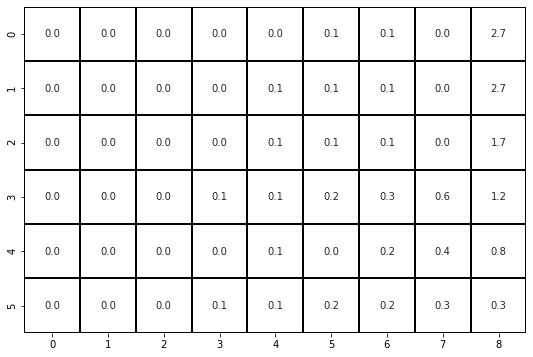

In [139]:
w,f,Q,policy,state_values = env.loop()

In [147]:
state_values

array([[0.01739204, 0.02032406, 0.03259645, 0.04119027, 0.04430065,
        0.0622786 , 0.05653043, 0.        , 2.74263846],
       [0.01242297, 0.01283097, 0.        , 0.04027337, 0.06531847,
        0.0801373 , 0.10834552, 0.        , 2.66035931],
       [0.01311807, 0.01384703, 0.        , 0.04453297, 0.06455741,
        0.10061438, 0.1041249 , 0.        , 1.71131324],
       [0.01507359, 0.02638711, 0.        , 0.07462301, 0.10097942,
        0.21121079, 0.2824538 , 0.62277735, 1.2225338 ],
       [0.01684657, 0.02740327, 0.03386992, 0.04598838, 0.05206651,
        0.        , 0.2493814 , 0.35603459, 0.75348232],
       [0.01843144, 0.02891875, 0.0320092 , 0.06517828, 0.07190281,
        0.1669057 , 0.21537616, 0.31048406, 0.29659338]])

In [148]:
Q

defaultdict(<function __main__.Maze.__init__.<locals>.<lambda>()>,
            {(0, 2): array([0.02185922, 0.01650733, 0.01180212, 0.03259645]),
             (0, 3): array([0.040565  , 0.02945925, 0.02977921, 0.04119027]),
             (1, 3): array([0.03925853, 0.03098349, 0.03954213, 0.04027337]),
             (1, 4): array([0.05222233, 0.03787393, 0.04091936, 0.06531847]),
             (1, 5): array([0.0801373 , 0.0422838 , 0.03950589, 0.05772473]),
             (1, 6): array([0.10834552, 0.05533374, 0.06615419, 0.0604942 ]),
             (0, 6): array([0.05653043, 0.04087204, 0.05240342, 0.04180971]),
             (0, 5): array([0.0622786 , 0.04822637, 0.04007207, 0.04747361]),
             (2, 5): array([0.09011417, 0.05598814, 0.04076412, 0.10061438]),
             (3, 5): array([0.17007845, 0.07270195, 0.06215187, 0.21121079]),
             (3, 4): array([0.0450205 , 0.04467823, 0.03945432, 0.10097942]),
             (2, 4): array([0.04446298, 0.04398473, 0.03798591, 0.06455741]

In [149]:
policy

{(0, 2): 'East',
 (0, 3): 'East',
 (1, 3): 'East',
 (1, 4): 'East',
 (1, 5): 'South',
 (1, 6): 'South',
 (0, 6): 'South',
 (0, 5): 'South',
 (2, 5): 'East',
 (3, 5): 'East',
 (3, 4): 'East',
 (2, 4): 'East',
 (2, 3): 'East',
 (0, 4): 'East',
 (2, 6): 'South',
 (3, 6): 'East',
 (4, 6): 'East',
 (4, 7): 'North',
 (5, 7): 'North',
 (5, 6): 'North',
 (5, 8): 'North',
 (4, 8): 'North',
 (3, 8): 'North',
 (2, 8): 'North',
 (1, 8): 'North',
 (0, 8): 'South',
 (0, 1): 'East',
 (1, 1): 'North',
 (1, 0): 'North',
 (2, 0): 'South',
 (0, 0): 'East',
 (2, 1): 'South',
 (3, 1): 'South',
 (4, 1): 'East',
 (4, 0): 'East',
 (5, 0): 'East',
 (5, 1): 'East',
 (5, 2): 'East',
 (5, 3): 'East',
 (4, 2): 'East',
 (4, 3): 'South',
 (3, 3): 'East',
 (3, 7): 'East',
 (5, 4): 'East',
 (5, 5): 'East',
 (4, 4): 'South',
 (3, 0): 'South'}